# Image Captioning Version

# Setup

In [1]:
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 4.0 MB 33.0 MB/s 
     |████████████████████████████████| 77 kB 8.7 MB/s 
     |████████████████████████████████| 895 kB 84.6 MB/s 
     |████████████████████████████████| 596 kB 70.1 MB/s 
     |████████████████████████████████| 6.6 MB 69.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y36xd87y
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-y36xd87y
     |████████████████████████████████| 53 kB 1.3 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369389 sha256=33e0d2fdf54aa6b26515230fe8cb53ab307162f0c6a981e33ec5bfa722d555b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-77qpxc31/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import shutil
from PIL import Image
import tqdm
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import vgg19, resnet18, densenet161
from torch.optim import AdamW, SGD, Adam
from torch.cuda.amp import GradScaler, autocast

# import transformers
# from transformers import BertModel, BertTokenizer

import clip


from collections import OrderedDict
from typing import Tuple, Union

In [4]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/11877-AMMML/dataset/"
DATASET_DIR = ROOT_DIR + "flickr8k/"

In [5]:
def get_all_files_from_dir(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        file_paths += [os.path.join(root, x) for x in files]
    return sorted(file_paths)

In [68]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.avgpool = nn.AvgPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            for conv, bn in [(self.conv1, self.bn1), (self.conv2, self.bn2), (self.conv3, self.bn3)]:
                x = self.relu(bn(conv(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        print(x.shape)

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text_for_explain(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # # x.shape = [batch_size, n_ctx, transformer.width]
        # # take features from the eot embedding (eot_token is the highest number in each sequence)
        # x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection
        return x
    
    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # # x.shape = [batch_size, n_ctx, transformer.width]
        # # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection
        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text_for_explain(text)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        text_features = text_features[torch.arange(text_features.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            # l.weight.data = l.weight.data.half()
            l.weight.data = l.weight.data.float()
            if l.bias is not None:
                # l.bias.data = l.bias.data.half()
                l.bias.data = l.bias.data.float()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    # tensor.data = tensor.data.half()
                    tensor.data = tensor.data.float()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    # attr.data = attr.data.half()
                    attr.data = attr.data.float()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith(f"transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval()

In [84]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [69]:
_, preprocess = clip.load("ViT-B/32")
checkpoint = torch.jit.load(ROOT_DIR + "ViT-B-32.pt")
state_dict = checkpoint.state_dict()
clip_model = build_model(state_dict)

In [70]:
EPOCHS = 1
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

# Data Preparation

In [71]:
df = pd.read_csv(DATASET_DIR + "captions.txt").head(5000)
print("There are", len(df.image.unique()), "images in the dataset")
print("There are", len(df.caption.unique()), "captions in the dataset")
print("Notice that one image might map to many captions here")

There are 1000 images in the dataset
There are 4998 captions in the dataset
Notice that one image might map to many captions here


In [72]:
image_paths = df.image.tolist()
texts = df.caption.tolist()
all_positive_pairs = [(image, text, 1) for image, text in zip(image_paths, texts)]

# negative sampling: random sample each, random shuffle, combine
negative_size = int(df.size * 0.5)
# sampled_images = df.image.unique().tolist()
sampled_images = random.sample(image_paths, negative_size)
random.shuffle(sampled_images[::-1])
sampled_texts = random.sample(texts, negative_size)
random.shuffle(sampled_texts[::-1])
negative_pairs = []
for image, text in zip(sampled_images, sampled_texts):
  if (image, text) not in all_positive_pairs:
    negative_pairs.append((image, text, 0))

positive_pairs = random.sample(all_positive_pairs, len(negative_pairs))
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)
print("Training set size", len(all_pairs))

Training set size 10000


In [73]:
image_paths = [item[0] for item in all_pairs]
texts = [item[1] for item in all_pairs]
labels = [item[2] for item in all_pairs]

In [74]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None, is_clip=False):
        super(ImageDataset, self).__init__()
        self.image_paths = [DATASET_DIR + "Images/" + x for x in image_paths]
        self.transform = transform
        self.idx_to_path = {i: image_path for i, image_path in enumerate(self.image_paths)}
        self.path_to_idx = {image_path: i for i, image_path in enumerate(self.image_paths)}
        self.is_clip = is_clip

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_filepath = self.idx_to_path[idx]
        if not self.is_clip:
          image = Image.open(image_filepath)
          if self.transform:
            try:
              image = self.transform(image)
            except:
              print(image_filepath)
        else:
          image = preprocess(Image.open(image_filepath))
        return image
    
    def get_by_path(self, path):
      image, _ =  self.__getitem__(self.path_to_idx[path])
      image = image[None, :]
      return image


class TextDataset(Dataset):
  def __init__(self, texts, targets, tokenizer, max_len, is_clip=False):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.is_clip = is_clip
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    # if target == 1:
    #   target = np.array([1, 0])
    # else:
    #   target = np.array([0, 1])

    if self.is_clip:
      encoding = clip.tokenize(text).flatten()
      return {
          'text': text,
          'clip_encoding': encoding,
          'targets': torch.tensor(target, dtype=torch.long)
      }
    else:
      encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        # pad_to_max_length=True,
        padding="max_length",
        return_attention_mask=True,
        return_tensors='pt',
      )

      return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
      }

In [76]:
# use the ImageNet transformation
imagenet_transform = transforms.Compose([transforms.Resize((256, 256)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

# Already double checked the order of ids in dataset and loader objects are as expected
image_dataset = ImageDataset(image_paths, imagenet_transform, is_clip=True)
image_dataloader = DataLoader(dataset=image_dataset, batch_size=BATCH_SIZE)

In [77]:
text_dataset = TextDataset(
    texts=texts,
    targets=labels,
    tokenizer=tokenizer,
    max_len=160,
    is_clip=True
  )

text_dataloader = DataLoader(dataset=text_dataset, batch_size=BATCH_SIZE)

In [78]:
assert len(image_dataloader) == len(text_dataloader)

# Model To Train

In [79]:
class MultimodalClipClassifier(nn.Module):
  def __init__(self, clip_model, n_classes):
    super(MultimodalClipClassifier, self).__init__()
    self.clip_model = clip_model
    # self.drop = nn.Dropout(p=0.3)
    self.combined_fc1 = nn.Linear(512*1, 256)
    self.combined_fc2 = nn.Linear(256, 128)
    self.output_fc = nn.Linear(128, n_classes)
    self.text_projection = clip_model.text_projection

    # Placeholder for raw input
    self.raw_image_input = None
    self.raw_language_input = None
    
    # placeholder for the gradients
    self.vision_gradients = None
    self.language_gradients = None
  
  def forward(self, image, text):
    self.raw_image_input = image.clone().detach().cpu().numpy()
    image.requires_grad = True
    h_vision = image.register_hook(self.vision_activations_hook)

    image_emb = self.clip_model.encode_image(image)
    text_emb = self.clip_model.encode_text_for_explain(text)
    h_language = text_emb.register_hook(self.language_activations_hook)
    text_emb = text_emb[torch.arange(text_emb.shape[0]), text.argmax(dim=-1)] @ self.text_projection

    # all_emb = torch.cat((text_emb, image_emb, text_emb * image_emb), 1)
    all_emb = text_emb * image_emb
    x_comb = F.relu(self.combined_fc1(all_emb))
    x_comb = F.relu(self.combined_fc2(x_comb))
    out = self.output_fc(x_comb)
    return out

  def get_vision_gradient(self):
    return self.vision_gradients

  def get_language_gradient(self):
    return self.language_gradients
  
   # method for the activation exctraction
  def get_vision_activations(self, x):
    return self.raw_image_input
  
  def get_language_activations(self):
    return self.raw_language_input

  def get_raw_vision_input(self):
    return self.raw_image_input

  def get_raw_language_input(self, text):
    return self.raw_language_input

  # hook for the gradients of the activations
  def vision_activations_hook(self, grad):
      self.vision_gradients = grad
  
  def language_activations_hook(self, grad):
      self.language_gradients = grad

In [80]:
print("Currently using device: {}\n".format(DEVICE))


model = MultimodalClipClassifier(clip_model=clip_model, n_classes=1)
model = model.to(DEVICE)

Currently using device: cuda



Index: 8419
Caption: A person standing behind two dogs interacting with one another .
Label: 0


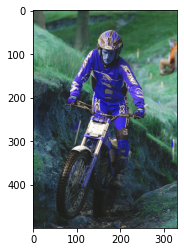

torch.Size([50, 1, 768])


0.15977222

In [81]:
# let's do a simple test on clip's encoding capability!
index = random.sample(range(len(all_pairs)), 1)[0]
print("Index:", index)
cv2_image = cv2.imread(DATASET_DIR + "Images/" + all_pairs[index][0])
# print(cv2_image.shape)
print("Caption:", all_pairs[index][1])
print("Label:", all_pairs[index][2])
plt.imshow(cv2_image)
plt.show()

image_encoding = model.clip_model.encode_image(preprocess(Image.open(DATASET_DIR + "Images/" + all_pairs[index][0]))[None, :]
                                               .to(DEVICE)).cpu().detach().numpy().flatten()
text_encoding = model.clip_model.encode_text(clip.tokenize(all_pairs[index][1]).to(DEVICE)).cpu().detach().numpy().flatten()

cos_sim = np.dot(image_encoding, text_encoding)/(np.linalg.norm(image_encoding) * np.linalg.norm(text_encoding))
cos_sim

In [41]:
print("Training Started...")
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Fine tune CLIP or use original CLIP?
for p in model.clip_model.parameters():
    p.requires_grad = False
for p in model.clip_model.get_submodule("token_embedding").parameters():
    p.requires_grad = True

# Scale gradients to use fp16 training
scaler = GradScaler()

model.train()

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for text_features, image_features in zip(text_dataloader, image_dataloader):
    with autocast():
      text_encodings = text_features["clip_encoding"].to(DEVICE)
      targets = text_features["targets"].to(DEVICE)
      image_features = image_features.to(DEVICE)

      model.zero_grad()
      output = model(image_features, text_encodings)
      # loss = criterion(torch.round(torch.sigmoid(output.squeeze())), targets.float())
      loss = criterion(output.squeeze(), targets.float())
    
    # scaler.scale(loss).backward() 
    loss.backward()
    # scaler.unscale_(optimizer)
    # nn.utils.clip_grad_norm_(model.parameters(), 5)
    # scaler.step(optimizer) 
    optimizer.step()
    # scaler.update()
    
    with torch.no_grad():
      acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - targets.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc.item()
      total_loss_train += loss.item()
    
  train_acc = total_acc_train / len(text_dataloader)
  train_loss = total_loss_train / len(text_dataloader)
  print("Epoch:", epoch + 1)
  print("Train accuracy:", train_acc)
  print("Train loss", train_loss)
  print()

torch.save(model.state_dict(), ROOT_DIR + "early_funsion.pt")

Training Started...
Epoch: 1
Train accuracy: 0.9507787539936102
Train loss 0.1372441349464793



# Explainer

Image label is:  1
Image caption is:  A man and a small girl floating on an innertube .
Prediction is 1.0 with confidence 0.9865541458129883


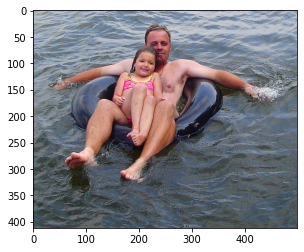

In [50]:
model.eval()
index = random.sample(range(len(all_pairs)), 1)[0]
sample_image_path = DATASET_DIR + "Images/" + all_pairs[index][0]
sample_text = all_pairs[index][1]
sample_label = all_pairs[index][2]

sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)
sample_image = preprocess(sample_image)
sample_image = sample_image[None, :].to(DEVICE)

encoding = clip.tokenize(sample_text).to(DEVICE)

output = model(sample_image, encoding)

confidence = torch.sigmoid(output.squeeze()).detach().cpu().numpy().tolist()
prediction = torch.round(torch.sigmoid(output.squeeze())).detach().cpu().numpy().tolist()
if prediction == 0.0:
  confidence = 1 - confidence

In [83]:
encoding.shape

torch.Size([1, 77])

In [51]:
output

tensor([[4.2955]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [52]:
output.backward()

In [62]:
vision_gradients = model.get_vision_gradient()
# pool the gradients across the channels, so that each channel have one gradient value
pooled_vision_gradients = torch.mean(vision_gradients, dim=[0, 2, 3])
pooled_vision_gradients_np = pooled_vision_gradients.detach().cpu().numpy()

# get the activations of the last convolutional layer
raw_vision_activations = model.get_vision_activations(sample_image)
vision_activations = np.zeros(raw_vision_activations.shape)

# weight the channels by corresponding gradients
for i in range(vision_activations[0].shape[0]):
  vision_activations[:, i, :, :] = raw_vision_activations[:, i, :, :] * pooled_vision_gradients_np[i]

vision_activations = vision_gradients.detach().cpu().numpy()
    
# average the channels of the activations
vision_heatmap = torch.mean(torch.from_numpy(vision_activations), axis=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
vision_heatmap = np.maximum(vision_heatmap, 0)

# normalize the heatmap
vision_heatmap /= torch.max(vision_heatmap)

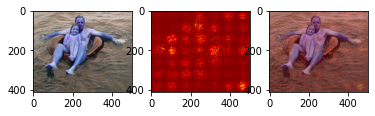

Image label is:  1
Image caption is:  A man and a small girl floating on an innertube .
Prediction is 1.0 with confidence 0.9865541458129883


In [63]:
# Plot heatmap together with the image from ORIGINAL RESOLUTION
plot_image = cv2.imread(sample_image_path)
updated_vision_heatmap = cv2.resize(np.array(vision_heatmap), (plot_image.shape[1], plot_image.shape[0]))
updated_vision_heatmap = np.uint8(255 * updated_vision_heatmap)
updated_vision_heatmap = cv2.applyColorMap(updated_vision_heatmap, cv2.COLORMAP_JET)
superimposed_img = updated_vision_heatmap * 0.5 + plot_image

f = plt.figure()
f.add_subplot(1, 3, 1)
plt.imshow(plot_image)
f.add_subplot(1, 3, 2)
plt.imshow(updated_vision_heatmap)
f.add_subplot(1, 3, 3)
plt.imshow(superimposed_img / np.max(superimposed_img))
plt.show(block=True)

print("Image label is: ", sample_label)
print("Image caption is: ", sample_text)
print("Prediction is", prediction, "with confidence", confidence)

In [64]:
language_gradients = model.get_language_gradient()
pooled_language_gradients = torch.mean(language_gradients, dim=2)
pooled_language_gradients_np = pooled_language_gradients.detach().cpu().numpy()

In [65]:
np.argmax(pooled_language_gradients_np)

13

In [ ]:
# tokens = tokenizer.convert_ids_to_tokens(sample_encoding["input_ids"][0])
# print(tokens)
# print(tokens[np.argmax(pooled_language_gradients_np) - 2 : np.argmax(pooled_language_gradients_np) + 2])